In [69]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import yaml
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import block_diag
from lightgbm import LGBMRegressor

DATA_PATH = Path("..") / "datasets"

SARCOS_PATH = DATA_PATH / "sarcos" / "processed"
PARKINSONS_PATH = DATA_PATH / "parkinsons" / "processed"
NANO_PATH = DATA_PATH / "nanoparticle" / "processed"

In [70]:
# try sarcos

x_train = np.loadtxt(SARCOS_PATH / "x_train.csv", delimiter=",")
x_val = np.loadtxt(SARCOS_PATH / "x_val.csv", delimiter=",")
x_test = np.loadtxt(SARCOS_PATH / "x_test.csv", delimiter=",")

y_train = np.loadtxt(SARCOS_PATH / "y_train.csv", delimiter=",")
y_val = np.loadtxt(SARCOS_PATH / "y_val.csv", delimiter=",")
y_test = np.loadtxt(SARCOS_PATH / "y_test.csv", delimiter=",")

x_ss = StandardScaler()
x_train = x_ss.fit_transform(x_train)
x_val = x_ss.transform(x_val)
x_test = x_ss.transform(x_test)

y_ss = StandardScaler()
y_train = y_ss.fit_transform(y_train)
y_val = y_ss.transform(y_val)
y_test = y_ss.transform(y_test)

print(x_train.shape, y_train.shape)

n_tasks = y_train.shape[1]

x_train = np.tile(x_train, (n_tasks, 1, 1))
x_val = np.tile(x_val, (n_tasks, 1, 1))
x_test = np.tile(x_test, (n_tasks, 1, 1))

y_train = np.transpose(y_train)
y_val = np.transpose(y_val)
y_test = np.transpose(y_test)

print(x_train.shape, y_train.shape)

(34262, 21) (34262, 7)
(7, 34262, 21) (7, 34262)


In [71]:
from mutar import DirtyModel

X = np.array(
    [
        [[3, 1, 0, 0, 0], [2, 0, 0, 0, 0], [1, 0, 0, 0, 0]],
        [[0, 2, 0, 0, 0], [-1, 3, 0, 0, 0], [1, -2, 0, 0, 0]],
    ],
    dtype=float,
)
coef = np.array([[1.0, 1.0], [0.0, -1], [0, 0], [0, 0], [0, 0]])

y = np.array([x.dot(c) for x, c in zip(X, coef.T)])
y += 0.1

print(f"X: (n_tasks, n_samples, n_features) {X.shape}")
print(X.shape, coef.T.shape, y.shape)

dirty = DirtyModel(alpha=0.15, beta=0.12).fit(X, y)
print(dirty.coef_shared_.shape)
print(dirty.coef_shared_)

print(dirty.coef_specific_.shape)
print(dirty.coef_specific_)

X: (n_tasks, n_samples, n_features) (2, 3, 5)
(2, 3, 5) (2, 5) (2, 3)
(5, 2)
[[ 0.4652447  0.3465437]
 [ 0.        -0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]]
(5, 2)
[[ 0.35453532  0.        ]
 [ 0.         -1.20766296]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


In [72]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression


def train_model(ModelClass, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(n_tasks)):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return output


dummy_results = train_model(DummyRegressor, strategy="mean")
linear_results = train_model(LinearRegression)

pd.DataFrame(linear_results).round(3).T

100%|██████████| 7/7 [00:00<00:00, 31.50it/s]


,train,val,test
task 0,0.074,0.074,0.074
task 1,0.103,0.102,0.102
task 2,0.091,0.094,0.090
task 3,0.051,0.053,0.050
task 4,0.146,0.151,0.144
task 5,0.274,0.277,0.271
task 6,0.065,0.067,0.064


In [73]:
from mutar import DirtyModel

model = DirtyModel(
    alpha=1.0,  # shared penalty
    beta=1.0,  # task-specific penalty
)
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

y_train_err = np.mean((y_train_pred - y_train) ** 2, axis=1)
y_val_err = np.mean((y_val_pred - y_val) ** 2, axis=1)
y_test_err = np.mean((y_test_pred - y_test) ** 2, axis=1)

columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]
df = pd.DataFrame(
    np.vstack([y_train_err, y_val_err, y_test_err]).T,
    columns=columns,
    index=index,
)

df.round(3)

,train,val,test
task 0,0.963,0.993,0.944
task 1,0.663,0.666,0.648
task 2,0.625,0.635,0.618
task 3,0.587,0.599,0.574
task 4,0.857,0.885,0.862
task 5,0.995,0.989,0.968
task 6,0.578,0.580,0.570


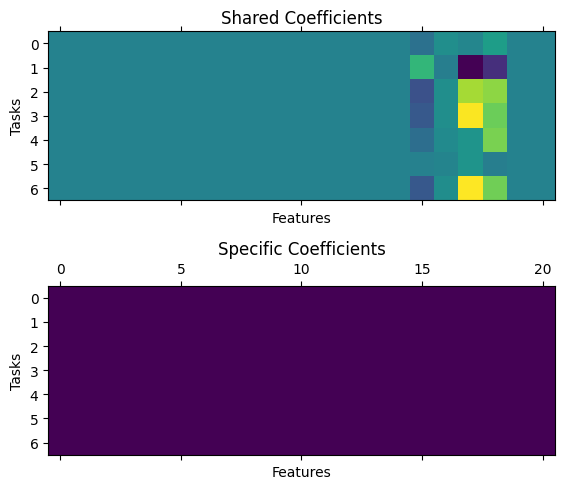

In [74]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)

axs[0].matshow(model.coef_shared_.T)
axs[0].set_title("Shared Coefficients")

axs[1].matshow(model.coef_specific_.T)
axs[1].set_title("Specific Coefficients")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()

In [75]:
from JOPLEn.multitask import MTJOPLEn
from JOPLEn.partitioner import VPartition

vpart_params = (
    {"n_partitions": 100, "n_cells": 2},
    {
        "max_iters": 1000,
        "lam_core": 5.0,
        "lam_task": 10,
        "core_alpha": 0.0,
        "task_alpha": 0.0,
        "print_epochs": 10,
        "mu": 0.1,
    },
)
# vpart_params = (
#     {"n_partitions": 100, "n_cells": 2},
#     {
#         "max_iters": 1000,
#         "lam_core": 1.0,
#         "lam_task": 0.7,
#         "core_alpha": 0.0,
#         "task_alpha": 0.0,
#         "print_epochs": 10,
#         "mu": 0.1,
#     },
# )

model = MTJOPLEn(
    VPartition,
    **vpart_params[0],
    random_state=0,
)
history = model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    **vpart_params[1],
)

[14:29:43]: Epoch     10 | TrL: 0.938009, 0.788927, 0.741040, 0.704970, 0.892093, 0.964636, 0.712027 | VaL: 0.951506, 0.790085, 0.746594, 0.712481, 0.907130, 0.961036, 0.714261 | CNorm: 12.121696 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:    7 | WsNz:    0,    0,    0,    0,    0,    0,    0
[14:29:43]: Epoch     20 | TrL: 0.949173, 0.792548, 0.753652, 0.713257, 0.905670, 0.974857, 0.718338 | VaL: 0.963244, 0.793955, 0.759420, 0.720993, 0.920774, 0.971357, 0.720538 | CNorm: 11.242280 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:    5 | WsNz:    0,    0,    0,    0,    0,    0,    0
[14:29:43]: Epoch     30 | TrL: 0.956681, 0.797647, 0.763240, 0.723181, 0.908670, 0.976435, 0.726372 | VaL: 0.971154, 0.799210, 0.769094, 0.731062, 0.923745, 0.972971, 0.728561 | CNorm: 10.723478 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:    5 | WsNz:    0,    0,    0,    0,    0,    0,    0
[14:29:43]: Epoch     40 | TrL: 0.961472, 0.800424, 0.7682

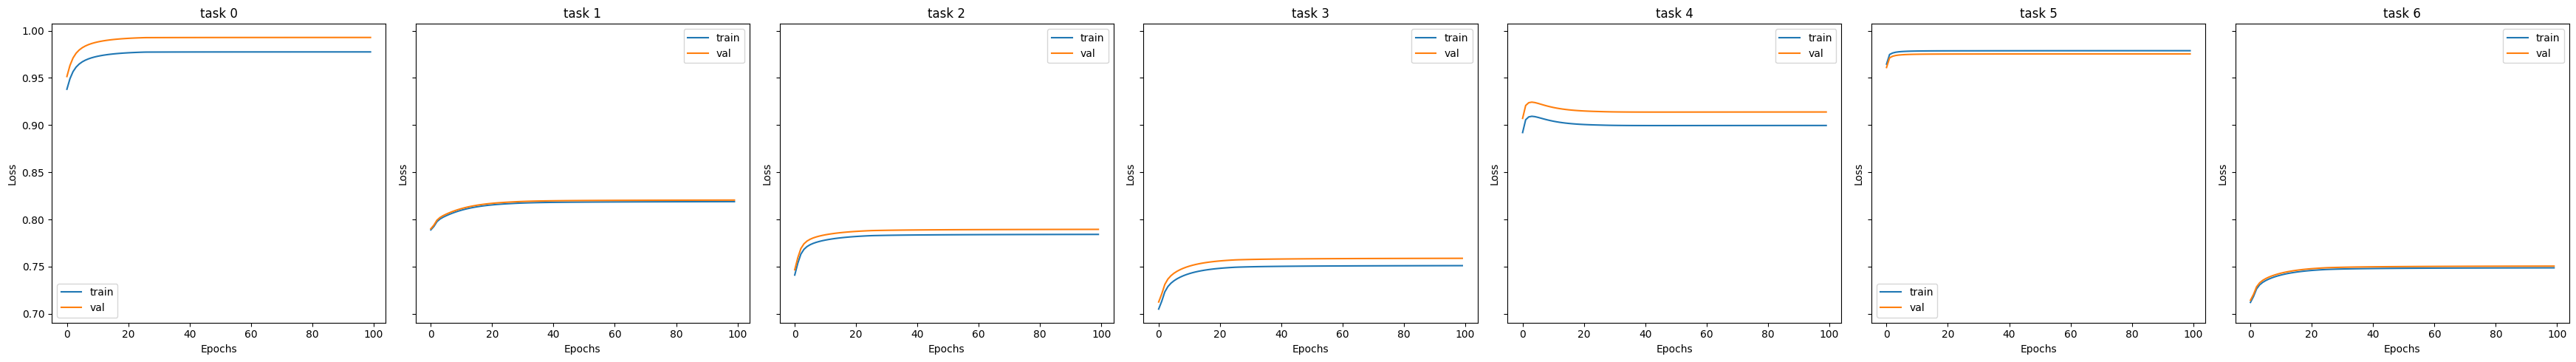

,train,val,test
task 0,0.956,0.986,0.936
task 1,0.670,0.673,0.657
task 2,0.615,0.623,0.608
task 3,0.564,0.576,0.551
task 4,0.809,0.835,0.814
task 5,0.958,0.952,0.931
task 6,0.561,0.563,0.555


In [76]:
fig, axs = plt.subplots(1, n_tasks, figsize=(5 * n_tasks, 5), sharey=True, sharex=True)

train_loss = np.array(history["train_loss"])
val_loss = np.array(history["val_loss"])

for i, ax in enumerate(axs):
    ax.plot(train_loss[:, i], label="train")
    ax.plot(val_loss[:, i], label="val")
    ax.set_title(f"task {i}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

plt.tight_layout()
plt.show()

y_train_pred = [model.predict(x_train[i], i).flatten() for i in range(n_tasks)]
y_val_pred = [model.predict(x_val[i], i).flatten() for i in range(n_tasks)]
y_test_pred = [model.predict(x_test[i], i).flatten() for i in range(n_tasks)]

y_train_err = np.mean((y_train_pred - y_train) ** 2, axis=1)
y_val_err = np.mean((y_val_pred - y_val) ** 2, axis=1)
y_test_err = np.mean((y_test_pred - y_test) ** 2, axis=1)

columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]
df = pd.DataFrame(
    np.vstack([y_train_err, y_val_err, y_test_err]).T,
    columns=columns,
    index=index,
)
df.round(3)

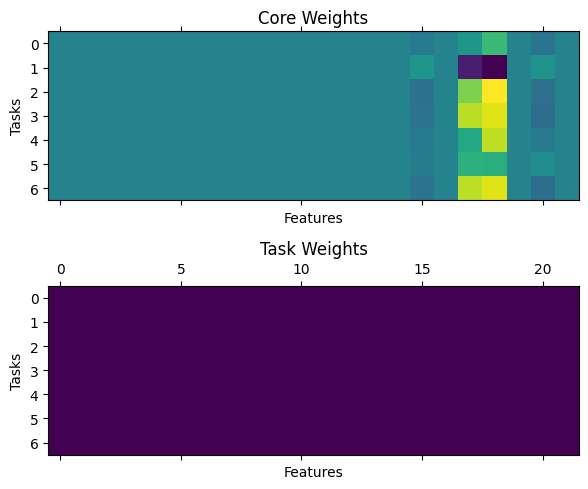

In [77]:
def max_signed_weights(weights):
    indices_max_abs = np.argmax(np.abs(weights), axis=-1)
    weights = np.take_along_axis(
        weights, indices_max_abs[..., np.newaxis], axis=-1
    ).squeeze(-1)
    return weights


core_weights = max_signed_weights(model.cwb.get())
task_weights = max_signed_weights(model.cws.get())

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)
axs[0].matshow(core_weights)
axs[0].set_title("Core Weights")
axs[1].matshow(task_weights)
axs[1].set_title("Task Weights")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

---

In [78]:
# try parkinsons

train = {}
val = {}
test = {}

for dir in sorted(PARKINSONS_PATH.iterdir(), key=lambda x: int(x.name)):
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[int(dir.name)] = {"x": x_train, "y": y_train}
    val[int(dir.name)] = {"x": x_val, "y": y_val}
    test[int(dir.name)] = {"x": x_test, "y": y_test}

In [79]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [80]:
from JOPLEn.partitioner import VPartition, RFPartition, GBPartition

model = MTJOPLEn(
    # GBPartition,
    # n_partitions=100,
    VPartition,
    n_partitions=100,
    n_cells=2,
    random_state=0,
)

history = model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=100,
    lam_core=5.0,
    lam_task=10,
    core_alpha=0.01,
    task_alpha=0.01,
    print_epochs=2,
    mu=0.05,
)

[14:29:54]: Epoch      2 | TrL: 0.982229, 0.987660, 0.981287, 0.972775, 0.984177, 0.980650, 0.986838, 0.997403, 0.991766, 0.989556, 0.982017, 0.989298, 0.984015, 0.989985, 0.927118, 0.972194, 0.990453, 0.978168, 0.986627, 0.994561, 0.984158, 0.989332, 0.962361, 0.989963, 0.978315, 0.981128, 0.973017, 0.991325, 0.985129, 0.988437, 0.988397, 0.978854, 0.981255, 0.988438, 0.991988, 0.993286, 0.932594, 0.996945, 0.993376, 0.992903, 0.990106, 0.963110 | VaL: 1.016756, 0.937125, 0.896314, 1.082976, 0.898275, 1.012415, 1.004208, 1.026289, 1.216776, 0.921827, 1.050522, 1.035041, 0.949545, 1.050943, 1.100406, 1.133020, 0.994415, 0.887716, 0.943724, 1.093006, 0.994107, 0.996595, 0.869784, 1.163501, 1.076051, 0.971236, 1.023663, 1.384726, 0.879138, 0.941597, 1.013551, 1.003798, 0.929718, 1.094979, 1.050313, 0.997329, 1.030944, 0.900497, 1.046968, 1.298331, 1.022778, 1.037451 | CNorm: 7.271019 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:   17 | WsNz:    0,    0,    0,    0,    0

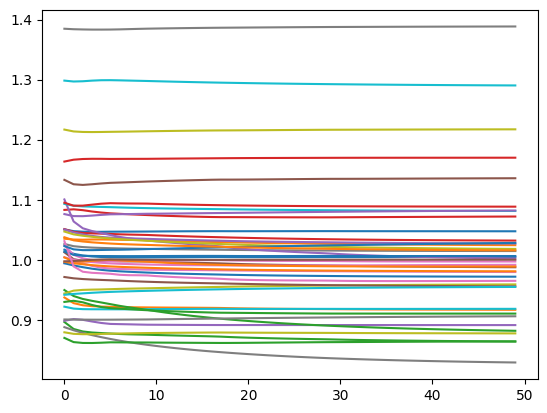

In [81]:
plt.plot(history["val_loss"], label="train")
plt.show()

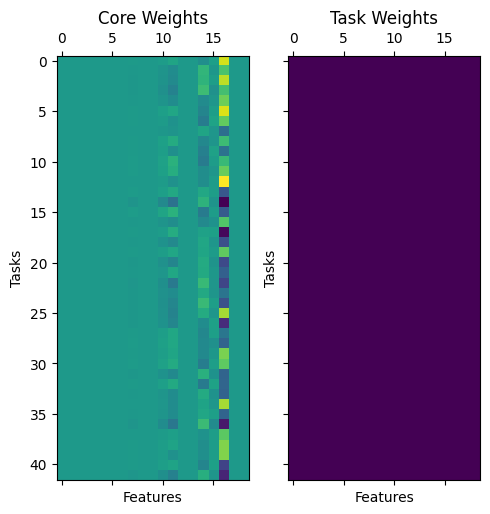

In [82]:
core_weights = max_signed_weights(model.cwb.get())
task_weights = max_signed_weights(model.cws.get())

fig, axs = plt.subplots(1, 2, figsize=(5, 10), sharey=True, sharex=True)
axs[0].matshow(core_weights)
axs[0].set_title("Core Weights")
axs[1].matshow(task_weights)
axs[1].set_title("Task Weights")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [83]:
def plot_strip(
    arr: list[np.ndarray],
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    ax=None,
):
    """
    Create a strip plot based on the list of y-values.
    """
    if ax is None:
        fig, ax = plt.subplots(**plot_kwargs)

    np.random.seed(random_state)
    y_values = np.arange(len(arr))[:, None] + np.random.uniform(
        -jitter, jitter, size=arr.shape
    )

    for xs, ys in zip(arr, y_values):
        ax.scatter(xs, ys, **scatter_kwargs)

    # for x_idx, x_values in enumerate(arr):
    #     # Apply jitter to x-axis positions
    #     y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in x_values]
    #     ax.scatter(x_values, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, x_values in enumerate(arr[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    ax.set_xlim(x_lim)
    ax.set_ylim(-0.5, len(arr) - 0.5)

    return ax, y_values

In [84]:
np.linalg.norm(core_weights, axis=0).shape

(19,)

In [87]:
np.linalg.norm(model.cwb.get(), axis=(0, 2))

(19,)

In [90]:
feature_mask = np.linalg.norm(model.cwb.get(), axis=(0, 2))[:-1] > 1e-1
print(feature_mask.sum())

y_train_pred, y_val_pred, y_test_pred = [], [], []
y_train_err, y_val_err, y_test_err = [], [], []

for i in range(n_tasks):
    lgbm = LGBMRegressor(random_state=0, verbose=-1)
    lgbm.fit(x_train[i][:, feature_mask], y_train[i])

    y_train_pred.append(lgbm.predict(x_train[i][:, feature_mask]))
    y_val_pred.append(lgbm.predict(x_val[i][:, feature_mask]))
    y_test_pred.append(lgbm.predict(x_test[i][:, feature_mask]))

    y_train_err.append(np.mean((y_train_pred[-1] - y_train[i]) ** 2))
    y_val_err.append(np.mean((y_val_pred[-1] - y_val[i]) ** 2))
    y_test_err.append(np.mean((y_test_pred[-1] - y_test[i]) ** 2))

6


In [91]:
def concat_datasets(
    X_datasets: list[np.ndarray], y_datasets: list[np.ndarray]
) -> tuple[np.ndarray]:
    padded_y = []
    padded_X = []
    mask = []

    num_datasets = len(y_datasets)
    max_samples = max([y.shape[0] for y in y_datasets])
    basis = np.eye(num_datasets, dtype=bool)

    for i, (y, X, b) in enumerate(zip(y_datasets, X_datasets, basis)):
        y = np.expand_dims(y, 0)
        X = np.expand_dims(X, 0)
        b = np.expand_dims(b, 1)

        task_padding = (i, num_datasets - i - 1)

        tmp_y = np.pad(y, [task_padding, (0, 0)], mode="constant")
        tmp_X = np.tile(X, (num_datasets, 1, 1))
        tmp_b = np.tile(b, (1, y.shape[1]))

        padded_y.append(tmp_y)
        padded_X.append(tmp_X)
        mask.append(tmp_b)

    y_out = np.concatenate(padded_y, axis=-1)
    x_out = np.concatenate(padded_X, axis=1)
    mask_out = np.concatenate(mask, axis=-1)

    return x_out, y_out, mask_out


def get_out_data(y_pred, mask_out):
    indices = [0] + list(np.cumsum(mask_out.sum(axis=1)))[:-1] + [None]
    tmp = y_pred[mask_out]
    return [tmp[i1:i2] for i1, i2 in zip(indices[:-1], indices[1:])]

In [92]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

model = DirtyModel(
    alpha=0.02,  # shared penalty
    beta=0.01,  # task-specific penalty
)
model.fit(x_train_out, y_train_out, train_mask_out)

DirtyModel(alpha=0.02, beta=0.01)

In [93]:
feature_mask = np.linalg.norm(model.coef_shared_[:, :-1].T, axis=0) > 1e-4
print(feature_mask.sum())

y_train_pred, y_val_pred, y_test_pred = [], [], []
y_train_err, y_val_err, y_test_err = [], [], []

for i in range(n_tasks):
    lgbm = LGBMRegressor(random_state=0, verbose=-1)
    lgbm.fit(x_train[i][:, feature_mask], y_train[i])

    y_train_pred.append(lgbm.predict(x_train[i][:, feature_mask]))
    y_val_pred.append(lgbm.predict(x_val[i][:, feature_mask]))
    y_test_pred.append(lgbm.predict(x_test[i][:, feature_mask]))

    y_train_err.append(np.mean((y_train_pred[-1] - y_train[i]) ** 2))
    y_val_err.append(np.mean((y_val_pred[-1] - y_val[i]) ** 2))
    y_test_err.append(np.mean((y_test_pred[-1] - y_test[i]) ** 2))

4


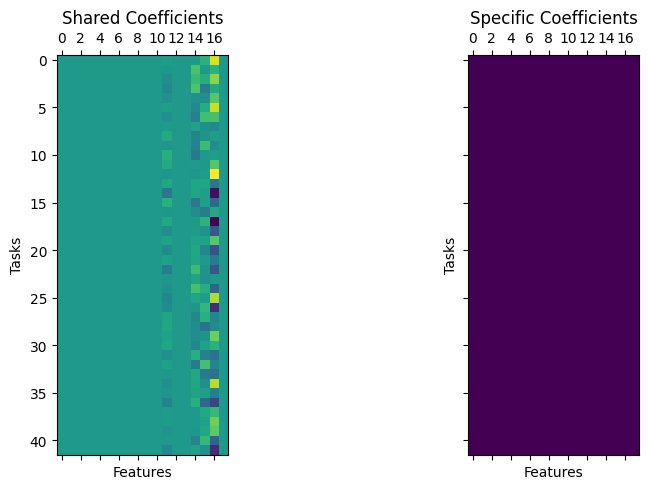

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

axs[0].matshow(model.coef_shared_.T)
axs[0].set_title("Shared Coefficients")

axs[1].matshow(model.coef_specific_.T)
axs[1].set_title("Specific Coefficients")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor


def train_model(ModelClass, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(n_tasks)):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return output


linear_results = train_model(LinearRegression)
naive_results = train_model(DummyRegressor, strategy="mean")
linear_test_err = [linear_results[f"task {i}"]["test"] for i in range(n_tasks)]
naive_test_err = [naive_results[f"task {i}"]["test"] for i in range(n_tasks)]

100%|██████████| 42/42 [00:00<00:00, 6887.20it/s]


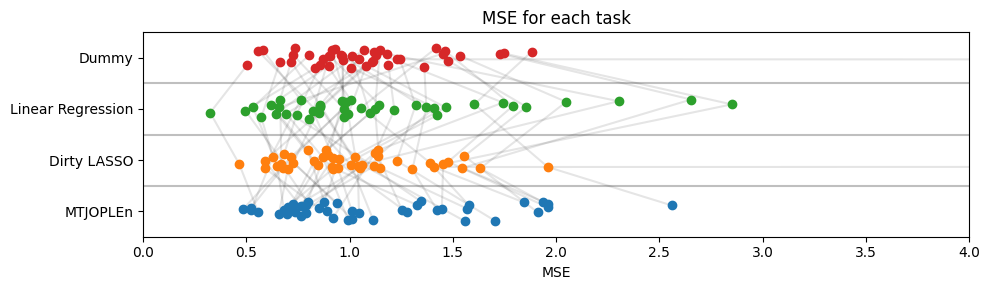

In [96]:
columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]

data = np.vstack([y_test_err, dl_test_err, linear_test_err, naive_test_err])

fig, ax = plt.subplots(figsize=(10, 3))

ax, y_values = plot_strip(
    data,
    scatter_kwargs={"marker": "o"},
    ax=ax,
)

ax.plot(data.reshape(4, -1), y_values, color="k", alpha=0.1, zorder=0)

ax.set_xlabel("MSE")
ax.set_yticks(range(4), ["MTJOPLEn", "Dirty LASSO", "Linear Regression", "Dummy"])
ax.set_title("MSE for each task")

ax.set_xlim(0, 4)
plt.tight_layout()
plt.show()

In [541]:
np.random.seed(0)

x = np.random.normal(size=(1000, 2))

# y1 = x[:, 0] ** 2 + x[:, 1]
# y2 = -x[:, 0] ** 2 + x[:, 1]

# y1 = np.sin(2 * x[:, 0]) + x[:, 1] / 3
# y2 = x[:, 0] / 3 + np.cos(2 * x[:, 1])

y1 = np.sin(x[:, 0] + x[:, 1])
y2 = np.cos(x[:, 0] - x[:, 1])

y = np.stack([y1, y2], axis=0)

In [542]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y1, mode="markers", marker=dict(color="red"))
)

# Add the second scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y2, mode="markers", marker=dict(color="blue"))
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

[0.50820364 0.37837968]


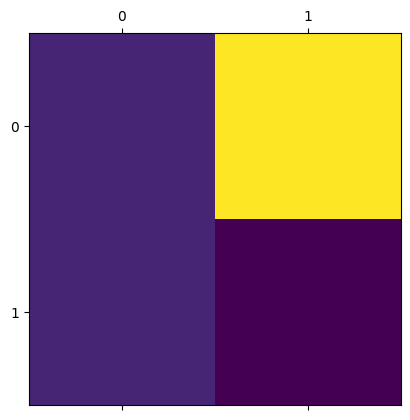

In [545]:
model = DirtyModel(alpha=0.4, beta=10)
model.fit(np.tile(np.expand_dims(x, 0), (2, 1, 1)), y)

y_pred = model.predict(np.tile(np.expand_dims(x, 0), (2, 1, 1)))
print(np.mean((y_pred - y) ** 2, axis=1))

plt.matshow(model.coef_shared_.T)
plt.show()

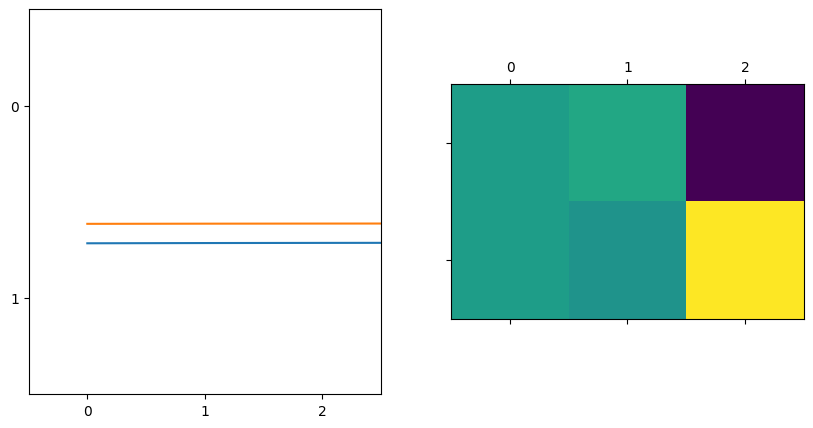

[0.51191828 0.37782288]


In [559]:
model = MTJOPLEn(
    VPartition,
    n_partitions=100,
    n_cells=10,
    random_state=0,
)

history = model.fit(
    np.tile(np.expand_dims(x, 0), (2, 1, 1)),
    y,
    max_iters=100,
    lam_core=2.05,
    lam_task=10,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=1,
    mu=0.01,
    verbose=0,
)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

axs[0].plot(history["train_loss"])
core_weights = max_signed_weights(model.cwb.get())
axs[1].matshow(core_weights)
plt.show()

y_pred = [model.predict(x, i).flatten() for i in range(2)]
print(np.mean([(yt - yp) ** 2 for yt, yp in zip(y, y_pred)], axis=1))

---

In [138]:
train = {}
val = {}
test = {}

dirs = sorted(NANO_PATH.iterdir())
dir_names = [dir.name for dir in dirs]

for dir in dirs:
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[dir.name] = {"x": x_train, "y": y_train}
    val[dir.name] = {"x": x_val, "y": y_val}
    test[dir.name] = {"x": x_test, "y": y_test}

In [139]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [140]:
from JOPLEn.partitioner import VPartition, RFPartition, GBPartition
from JOPLEn.enums import NormType

model = MTJOPLEn(
    GBPartition,
    n_partitions=100,
    # VPartition,
    # n_partitions=1000,
    n_cells=4,
    random_state=0,
)

history = model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=10000,
    lam_core=2.5,
    lam_task=100,
    # lam_core=100,
    # lam_task=100,
    core_alpha=0.01,
    task_alpha=0.01,
    print_epochs=100,
    mu=0.001,
    norm_type=NormType.L21,
)

[14:39:24]: Epoch    100 | TrL: 0.976005, 0.976138 | VaL: 0.989489, 0.972888 | CNorm: 1.042440 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:   72 | WsNz:    0,    0
[14:39:24]: Epoch    200 | TrL: 0.976983, 0.977173 | VaL: 0.990331, 0.973332 | CNorm: 0.990307 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:   60 | WsNz:    0,    0
[14:39:25]: Epoch    300 | TrL: 0.977054, 0.977094 | VaL: 0.990948, 0.973710 | CNorm: 0.985845 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:   59 | WsNz:    0,    0
[14:39:25]: Epoch    400 | TrL: 0.977085, 0.977153 | VaL: 0.991304, 0.973860 | CNorm: 0.980570 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:   59 | WsNz:    0,    0
[14:39:25]: Epoch    500 | TrL: 0.977027, 0.977171 | VaL: 0.991518, 0.973923 | CNorm: 0.978713 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:   57 | WsNz:    0,    0
[14:39:25]: Epoch    600 | TrL: 0.976817, 0.976935 | VaL: 0.991683, 0.974025 | CNorm:

In [141]:
feature_mask = np.linalg.norm(model.cwb.get(), axis=(0, 2))[:-1] > 1e-2
print(feature_mask.sum())

y_train_pred, y_val_pred, y_test_pred = [], [], []
y_train_err, y_val_err, y_test_err = [], [], []

for i in range(n_tasks):
    lgbm = LGBMRegressor(random_state=0, verbose=-1)
    lgbm.fit(x_train[i][:, feature_mask], y_train[i])

    y_train_pred.append(lgbm.predict(x_train[i][:, feature_mask]))
    y_val_pred.append(lgbm.predict(x_val[i][:, feature_mask]))
    y_test_pred.append(lgbm.predict(x_test[i][:, feature_mask]))

    y_train_err.append(np.mean((y_train_pred[-1] - y_train[i]) ** 2))
    y_val_err.append(np.mean((y_val_pred[-1] - y_val[i]) ** 2))
    y_test_err.append(np.mean((y_test_pred[-1] - y_test[i]) ** 2))

print("Train:", list(np.around(y_train_err, 2)))
print("Val:  ", list(np.around(y_val_err, 2)))
print("Test: ", list(np.around(y_test_err, 2)))

22
Train: [0.37, 0.52]
Val:   [1.01, 0.91]
Test:  [0.64, 1.13]


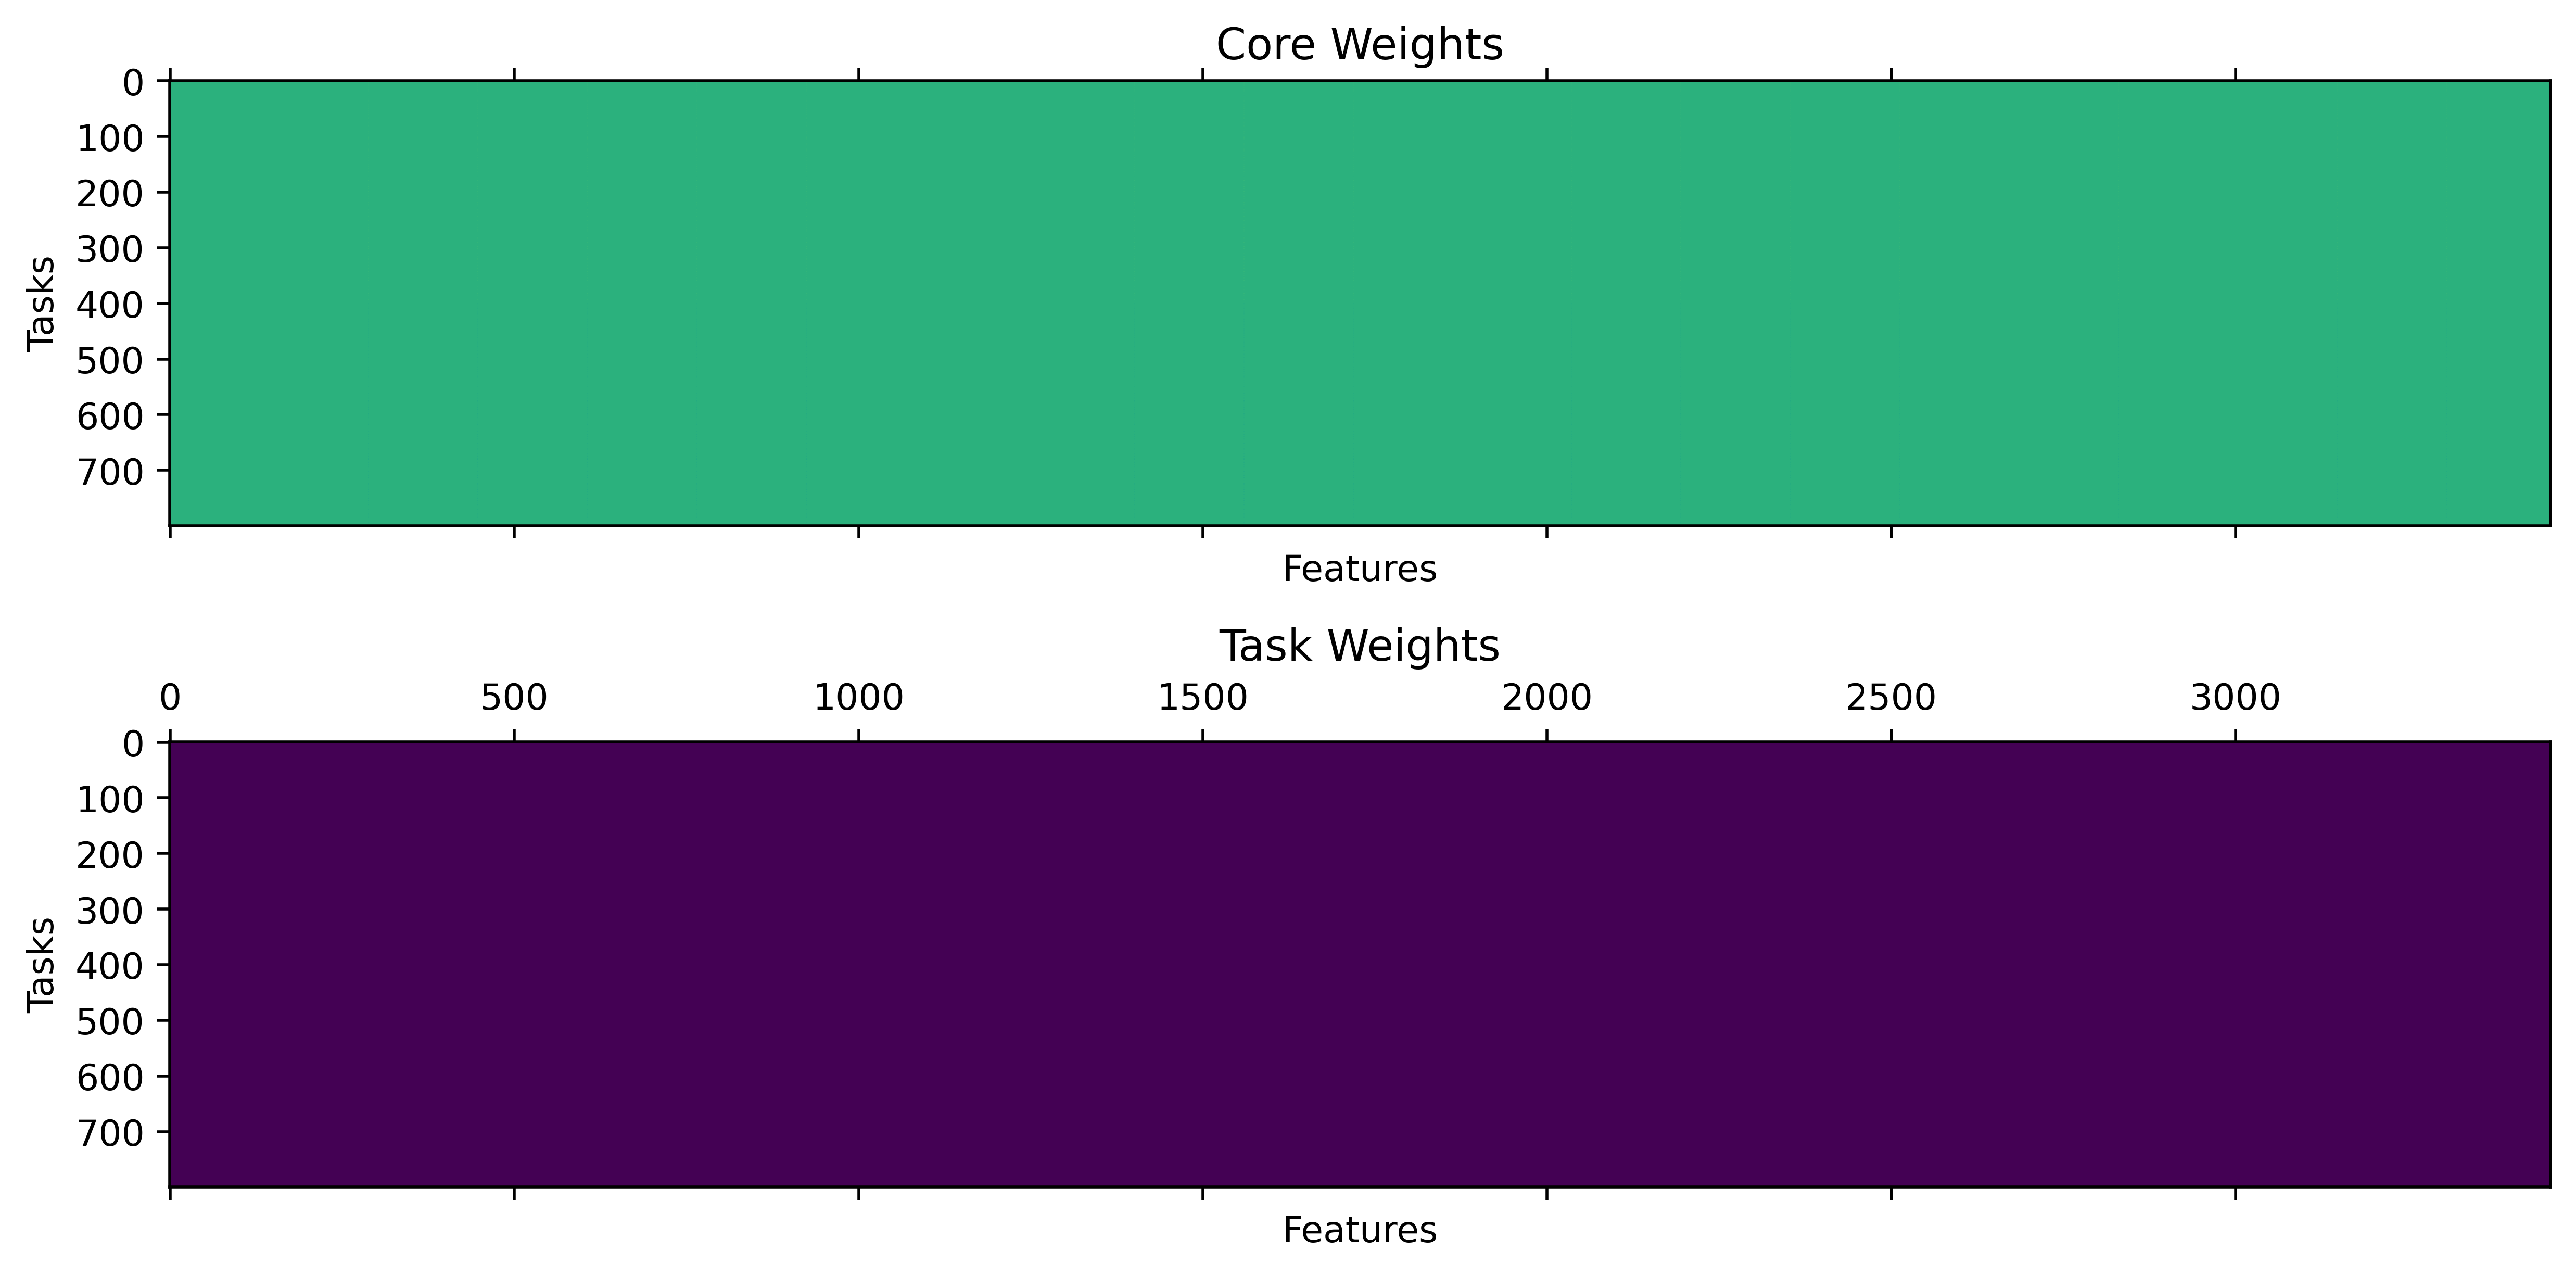

In [142]:
# core_weights = max_signed_weights(model.cwb.get())
# task_weights = max_signed_weights(model.cws.get())

core_weights = np.transpose(model.cwb.get(), (0, 2, 1)).reshape(
    -1, x_train[0].shape[1] + 1
)
task_weights = np.transpose(model.cws.get(), (0, 2, 1)).reshape(
    -1, x_train[0].shape[1] + 1
)

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True, dpi=500)
axs[0].matshow(core_weights, aspect="auto")
axs[0].set_title("Core Weights")
axs[1].matshow(task_weights, aspect="auto")
axs[1].set_title("Task Weights")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [143]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

model = DirtyModel(
    alpha=0.07,  # shared penalty
    beta=1.0,  # task-specific penalty
)
model.fit(x_train_out, y_train_out, train_mask_out)

dl_feature_mask = np.linalg.norm(model.coef_shared_[:, :-1].T, axis=0) > 1e-2
print(dl_feature_mask.sum())

dl_train_pred, dl_val_pred, dl_test_pred = [], [], []
dl_train_err, dl_val_err, dl_test_err = [], [], []

for i in range(n_tasks):
    lgbm = LGBMRegressor(random_state=0, verbose=-1)
    lgbm.fit(x_train[i][:, dl_feature_mask], y_train[i])

    dl_train_pred.append(lgbm.predict(x_train[i][:, dl_feature_mask]))
    dl_val_pred.append(lgbm.predict(x_val[i][:, dl_feature_mask]))
    dl_test_pred.append(lgbm.predict(x_test[i][:, dl_feature_mask]))

    dl_train_err.append(np.mean((dl_train_pred[-1] - y_train[i]) ** 2))
    dl_val_err.append(np.mean((dl_val_pred[-1] - y_val[i]) ** 2))
    dl_test_err.append(np.mean((dl_test_pred[-1] - y_test[i]) ** 2))

print("Train:", list(np.around(dl_train_err, 2)))
print("Val:  ", list(np.around(dl_val_err, 2)))
print("Test: ", list(np.around(dl_test_err, 2)))

21
Train: [0.07, 0.08]
Val:   [0.44, 0.59]
Test:  [0.36, 0.75]


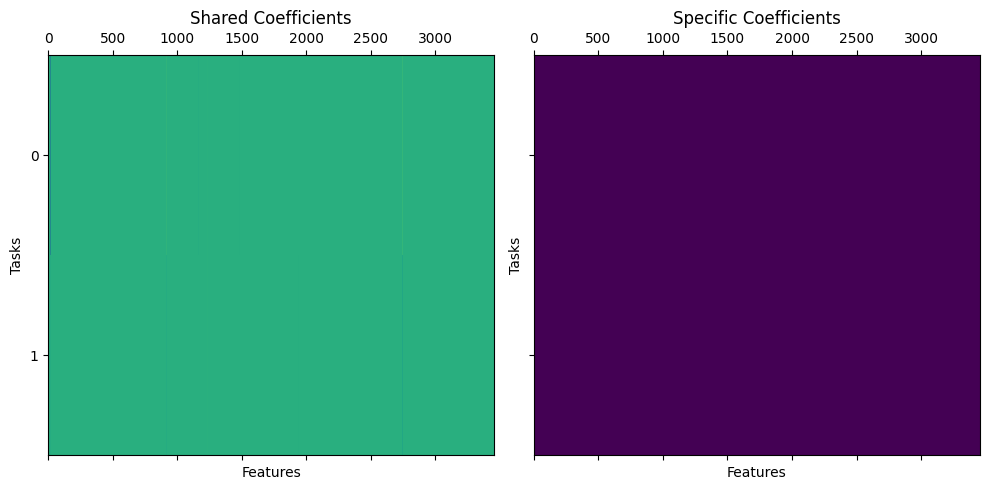

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

axs[0].matshow(model.coef_shared_.T, aspect="auto")
axs[0].set_title("Shared Coefficients")

axs[1].matshow(model.coef_specific_.T, aspect="auto")
axs[1].set_title("Specific Coefficients")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor


def train_model(ModelClass, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(n_tasks)):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return output


linear_results = train_model(LinearRegression)
naive_results = train_model(DummyRegressor, strategy="mean")
lgbm_results = train_model(LGBMRegressor, random_state=0, verbose=-1)
linear_test_err = [linear_results[f"task {i}"]["test"] for i in range(n_tasks)]
naive_test_err = [naive_results[f"task {i}"]["test"] for i in range(n_tasks)]
lgbm_test_err = [lgbm_results[f"task {i}"]["test"] for i in range(n_tasks)]

100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


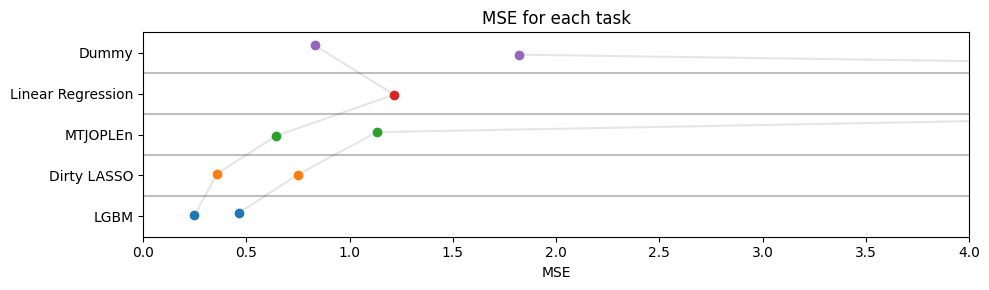

In [146]:
columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]

data = np.vstack(
    [lgbm_test_err, dl_test_err, y_test_err, linear_test_err, naive_test_err]
)

fig, ax = plt.subplots(figsize=(10, 3))

ax, y_values = plot_strip(
    data,
    scatter_kwargs={"marker": "o"},
    ax=ax,
)

ax.plot(data.reshape(5, -1), y_values, color="k", alpha=0.1, zorder=0)

ax.set_xlabel("MSE")
ax.set_yticks(
    range(5), ["LGBM", "Dirty LASSO", "MTJOPLEn", "Linear Regression", "Dummy"]
)
ax.set_title("MSE for each task")

ax.set_xlim(0, 4)
plt.tight_layout()
plt.show()

In [158]:
path = NANO_PATH / "logp" / "metadata.yaml"
metadata = yaml.load(path.read_text(), Loader=yaml.SafeLoader)
features = np.array(metadata["features"])

print("JOPLEn features")
print(features[feature_mask])
print()
print("DirtyLasso Features")
print(features[dl_feature_mask])

JOPLEn features
['mass_whim_rel_axis3' 'mass_whim_k' 'unweighted_cchn' 'mass_cchn'
 'vdw_volume_cchn' 'electronegativity_cchn' 'polarizability_cchn'
 'covalent_radius_cchn' 'electron_affinity_cchn' 'nvalence_cchn'
 'zeff_cchn' 'ionization_energy1_cchn' 'ionization_energy2_cchn'
 'ionization_energy3_cchn' 'melting_point_cchn' 'boiling_point_cchn'
 'thermal_conductivity_cchn' 'fusion_heat_cchn' 'evaporation_heat_cchn'
 'atomic_volume_cchn' 'density_cchn' 'specific_heat_cchn']

DirtyLasso Features
['vdw_volume_variance' 'electronegativity_variance'
 'electron_affinity_variance' 'ionization_energy1_variance'
 'mass_whim_rel_axis3' 'mass_whim_k' 'electron_affinity_whim_ax_density1'
 'vdw_volume_convhull_first_quartile'
 'electron_affinity_convhull_first_quartile' 'unweighted_cccc'
 'unweighted_ccch' 'unweighted_hhoo' 'mass_cccc' 'mass_ccch' 'mass_hhoo'
 'vdw_volume_cccc' 'vdw_volume_ccch' 'vdw_volume_hhoo'
 'electronegativity_ccch' 'polarizability_ccch' 'fusion_heat_hhhx']


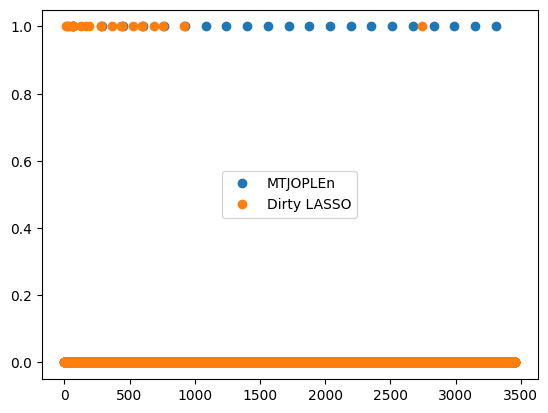

In [149]:
plt.plot(feature_mask, "o", label="MTJOPLEn")
plt.plot(dl_feature_mask, "o", label="Dirty LASSO")
plt.legend()